In [1]:
import os
import pickle

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from scripts import constants
from sklearn.cluster import KMeans

In [2]:
dataset = "haber_2017"
split_key = constants.DATASET_SPLIT_LOOKUP[dataset]["split_key"]
background_value = constants.DATASET_SPLIT_LOOKUP[dataset]["background_value"]
label_key = constants.DATASET_SPLIT_LOOKUP[dataset]["label_key"]

methods = [
    "scVI",
    "CPLVM",
    "CGLVM",
    "contrastiveVI",
]

latent_size = 10

In [3]:
adata = sc.read_h5ad(
    os.path.join(
        constants.DEFAULT_DATA_PATH,
        f"{dataset}/preprocessed/adata_top_2000_genes.h5ad",
    ),
)

target_adata = adata[adata.obs[split_key] != background_value]
background_adata = adata[adata.obs[split_key] == background_value]

target_labels = target_adata.obs[label_key]
target_unique_labels = target_adata.obs[label_key].unique().tolist()
styled_target_labels = [label.replace("_", "-").capitalize() for label in target_unique_labels]

cell_type_unique_labels = target_adata.obs["cell_type"].unique().tolist()

In [4]:
performance_df = pd.read_csv(
    os.path.join("/projects/leelab/contrastiveVI/results-different-normalization-ethan/", "performance_summary.csv"),
)
performance_df = performance_df[
    (performance_df["dataset"] == dataset)
    & (performance_df["latent_size"] == latent_size)
]

results_dict = {
    method: {
        "silhouette": {},
        "adjusted_rand_index": {},
        "normalized_mutual_info": {},
        "unsupervised_cluster_accuracy": {},
    } for method in methods
}
for method in methods:
    for metric in results_dict[method].keys():
        method_metrics = performance_df[
            performance_df["method"] == method
        ][metric].tolist()
    
        results_dict[method][metric] = {
            "mean": np.mean(method_metrics),
            "std": np.std(method_metrics),
        }
        results_dict[method][metric]["stderr"] = (
            results_dict[method][metric]["std"] / np.sqrt(len(method_metrics))
        )

In [5]:
method_latent_adata_dict = {}
for method in methods:
    print(f"Getting AnnData for {method}...")
    for seed in tqdm(constants.DEFAULT_SEEDS):
        latent = np.load(
            os.path.join(
                constants.DEFAULT_RESULTS_PATH,
                dataset,
                method,
                f"latent_{latent_size}",
                f"{seed}",
                "latent_representations.npy",
            ),
        )
        latent_adata = ad.AnnData(
            X=latent,
            obs=target_adata.obs,
            var=pd.DataFrame(
                index=[f"latent_dim_{i}" for i in range(latent.shape[1])]
            ),
        )
        
        sc.pp.neighbors(latent_adata)
        sc.tl.umap(latent_adata)
        sc.pp.pca(latent_adata, n_comps=2)
        
        if method not in method_latent_adata_dict.keys():
            method_latent_adata_dict[method] = {}
        
        method_latent_adata_dict[method][seed] = latent_adata

Getting AnnData for scVI...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.56s/it]


Getting AnnData for CPLVM...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.93s/it]


Getting AnnData for CGLVM...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.17s/it]


Getting AnnData for contrastiveVI...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:10<00:00, 14.11s/it]


In [6]:
import torch

seeds = constants.DEFAULT_SEEDS
device = 'cuda:1'
contrastiveVI_models = [torch.load(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/contrastiveVI/latent_{latent_size}/{seed}/model.ckpt",
    ),
    map_location=device
) for seed in seeds]
contrastiveVI_background_representations = [model.get_latent_representation(
    adata=target_adata, representation_kind="background") for model in contrastiveVI_models]

scVI_models = [torch.load(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/scVI/latent_{latent_size}/{seed}/model.ckpt",
    ),
    map_location=device
) for seed in seeds]
scVI_latent_representations = [model.get_latent_representation(
    adata=target_adata) for model in scVI_models]

cplvm_models = [pickle.load(open(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/CPLVM/latent_{latent_size}/{seed}/model.pkl",
    ), "rb"),
) for seed in seeds]
cplvm_background_representations = [model["qzy_mean"] for model in cplvm_models]

cglvm_models = [pickle.load(open(
    os.path.join(
        constants.DEFAULT_RESULTS_PATH,
        f"{dataset}/CGLVM/latent_{latent_size}/{seed}/model.pkl",
    ), "rb"),
) for seed in seeds]
cglvm_background_representations = [model["qzy_mean"] for model in cglvm_models]

background_representation_dict = {
    "contrastiveVI": contrastiveVI_background_representations,
    "CPLVM": cplvm_background_representations,
    "CGLVM": cglvm_background_representations,
    "scVI": scVI_latent_representations
}

Global seed set to 0
During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


INFO     Received view of anndata, making copy.                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 4481 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


/homes/gws/clin25/miniconda3/envs/contrastive-vi-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Received view of anndata, making copy.                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.layers["count"]                                               
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 4481 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              
INFO     Input adata not setup with scvi. attempting to tran

In [7]:
method_background_latent_adata_dict = {}

method = "contrastiveVI"
for seed, latent in zip(constants.DEFAULT_SEEDS, contrastiveVI_background_representations):
    latent_adata = ad.AnnData(
        X=latent,
        obs=target_adata.obs,
        var=pd.DataFrame(
            index=[f"latent_dim_{i}" for i in range(latent.shape[1])]
        ),
    )

    sc.pp.neighbors(latent_adata)
    sc.tl.umap(latent_adata)
    sc.pp.pca(latent_adata, n_comps=2)

    if method not in method_background_latent_adata_dict.keys():
        method_background_latent_adata_dict[method] = {}

    method_background_latent_adata_dict[method][seed] = latent_adata

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from scvi.model._metrics import unsupervised_clustering_accuracy
from scripts.eval_utils import evaluate_latent_representations

labels = target_adata.obs["cell_type"]
one_hot_labels = LabelEncoder().fit_transform(labels)

bg_silhouette_results_dict = {}
bg_ari_results_dict = {}
bg_nmi_results_dict = {}
bg_uca_results_dict = {}

for model_name, latent_list in background_representation_dict.items():
    print(f"Evaluating {model_name} representations...")
    silhouette_results = []
    ari_results = []
    nmi_results = []
    uca_results = []
    
    for latent in tqdm(latent_list):
        metrics = evaluate_latent_representations(one_hot_labels, latent, clustering_seed=123)
        silhouette_results.append(metrics["silhouette"])
        ari_results.append(metrics["adjusted_rand_index"])
        nmi_results.append(metrics["normalized_mutual_info"])
        uca_results.append(metrics["unsupervised_cluster_accuracy"])
        
    bg_silhouette_results_dict[model_name] = silhouette_results
    bg_ari_results_dict[model_name] = ari_results
    bg_nmi_results_dict[model_name] = nmi_results
    bg_uca_results_dict[model_name] = uca_results
    
print("Done!")

Evaluating contrastiveVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.10s/it]


Evaluating CPLVM representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]


Evaluating CGLVM representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.54s/it]


Evaluating scVI representations...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.68s/it]

Done!


In [9]:
target_label_palette = ["maroon", "gray"]

In [11]:
bg_silhouette_results_dict

{'contrastiveVI': [0.14471275, 0.14111947, 0.13982886, 0.1502129, 0.14106911],
 'CPLVM': [0.10507571, 0.07550161, 0.111385755, 0.103648275, 0.069705226],
 'CGLVM': [0.02704343, 0.03133623, 0.035950348, 0.038291086, 0.046151903],
 'scVI': [0.144143, 0.13289057, 0.1251247, 0.14309305, 0.124164574]}

Text(0.5, 1.0, 'Cell Type Separation')

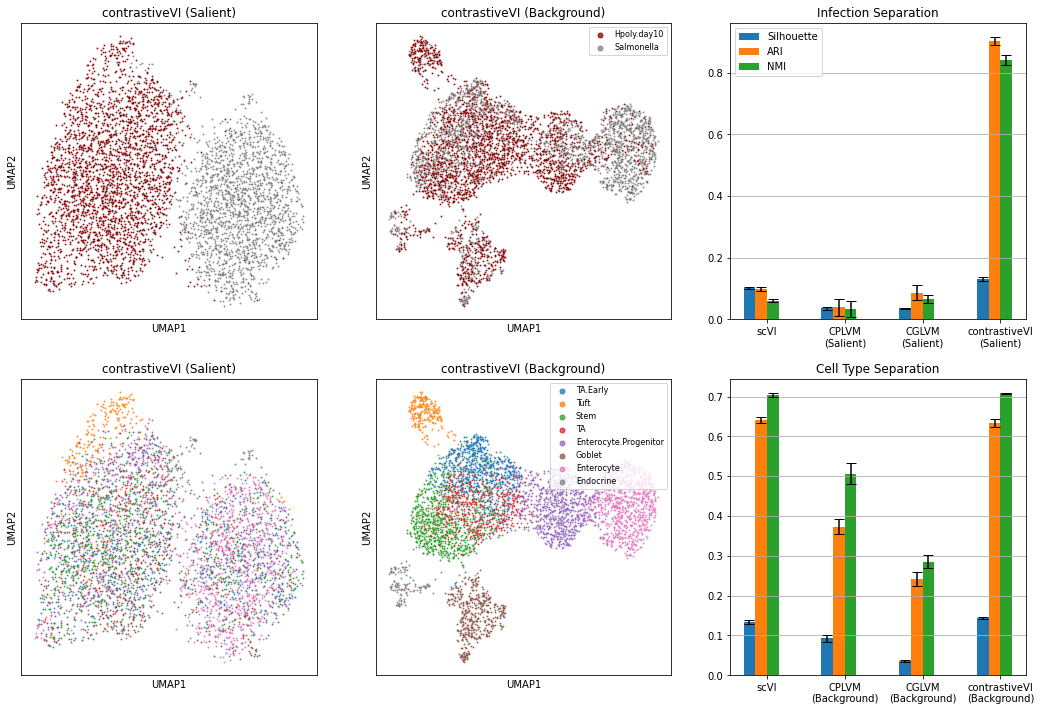

In [13]:
from scipy.stats import sem

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
width = 0.15  # Bar width
capsize = 5  # Error bar width
var_statistic = "stderr"
alpha = 0.75

seed = 789
rep = method_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
for i, label in enumerate(target_unique_labels):
    ax1.scatter(
        rep[:, 0][target_labels == label],
        rep[:, 1][target_labels == label],
        s=1,
        label=styled_target_labels[i],
        color=target_label_palette[i],
        alpha=alpha,
    )
    
ax1.set_title("contrastiveVI (Salient)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")

rep = method_background_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
for i, label in enumerate(target_unique_labels):
    ax2.scatter(
        rep[:, 0][target_labels == label],
        rep[:, 1][target_labels == label],
        s=1,
        label=styled_target_labels[i],
        color=target_label_palette[i],
        alpha=alpha,
    )
    
ax2.set_title("contrastiveVI (Background)")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")
ax2.legend(markerscale=5, fontsize=8)

plot_ordered_methods = [
    "scVI",
    "CPLVM",
    "CGLVM",
    "contrastiveVI",
]
x = np.arange(len(plot_ordered_methods))

ax3.bar(
    x,
    [results_dict[method]["silhouette"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["silhouette"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="Silhouette",
)
ax3.bar(
    x + width,
    [results_dict[method]["adjusted_rand_index"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["adjusted_rand_index"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="ARI",
)
ax3.bar(
    x + width * 2,
    [results_dict[method]["normalized_mutual_info"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["normalized_mutual_info"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="NMI",
)

xticklabels = []
for method in plot_ordered_methods:
    if method == "scVI":
        xticklabels.append(method)
    else:
        xticklabels.append(f"{method}\n(Salient)")
ax3.set_xticks(x + 1.5*width)
ax3.set_xticklabels(xticklabels)
ax3.grid(axis="y")
ax3.legend(loc="upper left")
ax3.set_title("Infection Separation")

rep = method_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
cell_type_labels = target_adata.obs['cell_type']
for i, label in enumerate(cell_type_unique_labels):
    ax4.scatter(
        rep[:, 0][cell_type_labels == label],
        rep[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=alpha,
    )
    
ax4.set_title("contrastiveVI (Salient)")
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_xlabel("UMAP1")
ax4.set_ylabel("UMAP2")

rep = method_background_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
cell_type_labels = target_adata.obs['cell_type']
for i, label in enumerate(cell_type_unique_labels):
    ax5.scatter(
        rep[:, 0][cell_type_labels == label],
        rep[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=alpha,
    )
    
ax5.set_title("contrastiveVI (Background)")
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_xlabel("UMAP1")
ax5.set_ylabel("UMAP2")
ax5.legend(markerscale=5, fontsize=8, loc='upper right')

model_labels = plot_ordered_methods
ax6.bar(
    x,
    [np.mean(bg_silhouette_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_silhouette_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="Silhouette",
)
ax6.bar(
    x + width,
    [np.mean(bg_ari_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_ari_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="ARI",
)
ax6.bar(
    x + width * 2,
    [np.mean(bg_nmi_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_nmi_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="NMI",
)

xticklabels = []
for method in plot_ordered_methods:
    if method == "scVI":
        xticklabels.append(method)
    else:
        xticklabels.append(f"{method}\n(Background)")
ax6.set_xticks(x + 1.5*width)
ax6.set_xticklabels(xticklabels)
ax6.grid(axis="y")
ax6.set_title("Cell Type Separation")

Text(0.5, 1.0, 'Cell Type Separation')

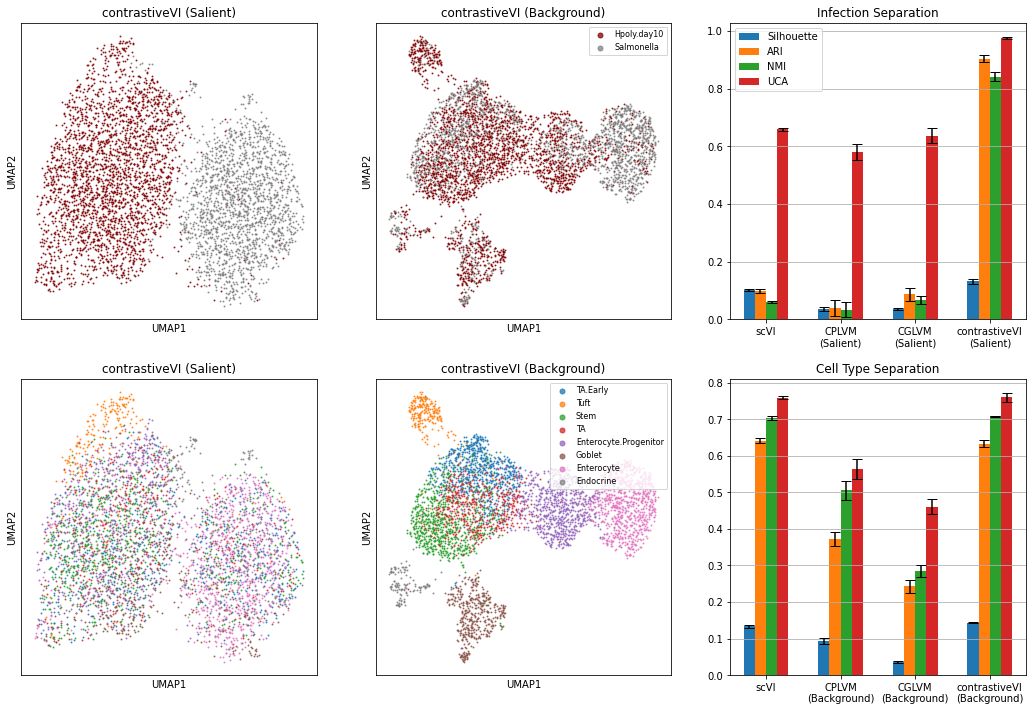

In [14]:
from scipy.stats import sem

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 12))
width = 0.15  # Bar width
capsize = 5  # Error bar width
var_statistic = "stderr"
alpha = 0.75

seed = 789
rep = method_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
for i, label in enumerate(target_unique_labels):
    ax1.scatter(
        rep[:, 0][target_labels == label],
        rep[:, 1][target_labels == label],
        s=1,
        label=styled_target_labels[i],
        color=target_label_palette[i],
        alpha=alpha,
    )
    
ax1.set_title("contrastiveVI (Salient)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("UMAP1")
ax1.set_ylabel("UMAP2")

rep = method_background_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
for i, label in enumerate(target_unique_labels):
    ax2.scatter(
        rep[:, 0][target_labels == label],
        rep[:, 1][target_labels == label],
        s=1,
        label=styled_target_labels[i],
        color=target_label_palette[i],
        alpha=alpha,
    )
    
ax2.set_title("contrastiveVI (Background)")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")
ax2.legend(markerscale=5, fontsize=8)

plot_ordered_methods = [
    "scVI",
    "CPLVM",
    "CGLVM",
    "contrastiveVI",
]
x = np.arange(len(plot_ordered_methods))

ax3.bar(
    x,
    [results_dict[method]["silhouette"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["silhouette"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="Silhouette",
)
ax3.bar(
    x + width,
    [results_dict[method]["adjusted_rand_index"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["adjusted_rand_index"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="ARI",
)
ax3.bar(
    x + width * 2,
    [results_dict[method]["normalized_mutual_info"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["normalized_mutual_info"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="NMI",
)

ax3.bar(
    x + width * 3,
    [results_dict[method]["unsupervised_cluster_accuracy"]["mean"] for method in plot_ordered_methods],
    width,
    yerr=[results_dict[method]["unsupervised_cluster_accuracy"][var_statistic] for method in plot_ordered_methods],
    capsize=capsize,
    label="UCA",
)

xticklabels = []
for method in plot_ordered_methods:
    if method == "scVI":
        xticklabels.append(method)
    else:
        xticklabels.append(f"{method}\n(Salient)")
ax3.set_xticks(x + 1.5*width)
ax3.set_xticklabels(xticklabels)
ax3.grid(axis="y")
ax3.legend(loc="upper left")
ax3.set_title("Infection Separation")

rep = method_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
cell_type_labels = target_adata.obs['cell_type']
for i, label in enumerate(cell_type_unique_labels):
    ax4.scatter(
        rep[:, 0][cell_type_labels == label],
        rep[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=alpha,
    )
    
ax4.set_title("contrastiveVI (Salient)")
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_xlabel("UMAP1")
ax4.set_ylabel("UMAP2")

rep = method_background_latent_adata_dict["contrastiveVI"][seed].obsm["X_umap"]
cell_type_labels = target_adata.obs['cell_type']
for i, label in enumerate(cell_type_unique_labels):
    ax5.scatter(
        rep[:, 0][cell_type_labels == label],
        rep[:, 1][cell_type_labels == label],
        s=1,
        label=label,
        alpha=alpha,
    )
    
ax5.set_title("contrastiveVI (Background)")
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_xlabel("UMAP1")
ax5.set_ylabel("UMAP2")
ax5.legend(markerscale=5, fontsize=8, loc='upper right')

model_labels = plot_ordered_methods
ax6.bar(
    x,
    [np.mean(bg_silhouette_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_silhouette_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="Silhouette",
)
ax6.bar(
    x + width,
    [np.mean(bg_ari_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_ari_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="ARI",
)
ax6.bar(
    x + width * 2,
    [np.mean(bg_nmi_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_nmi_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="NMI",
)
ax6.bar(
    x + width * 3,
    [np.mean(bg_uca_results_dict[model_label]) for model_label in model_labels],
    width,
    yerr=[sem(bg_uca_results_dict[model_label]) for model_label in model_labels],
    capsize=capsize,
    label="UCA",
)

xticklabels = []
for method in plot_ordered_methods:
    if method == "scVI":
        xticklabels.append(method)
    else:
        xticklabels.append(f"{method}\n(Background)")
ax6.set_xticks(x + 1.5*width)
ax6.set_xticklabels(xticklabels)
ax6.grid(axis="y")
ax6.set_title("Cell Type Separation")